# 4 Задание
1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.
1. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
1. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
1. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.
1. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)
1. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
data_w = data.copy().resample('w').mean()
data_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


Удалим признаки, которые потеряли смысл в недельном ресемпле: это час, дневные признаки, а так же год, так как тренда нет.

In [4]:
data_w.drop(['hour','is_holiday','is_prev_holiday',
             'is_next_holiday','dayofweek','dayofyear',
             'dayofmonth','year'], axis=1,inplace=True)
data_w.head()

,PJME_MW,month,quarter,weekofyear
Date,,,,
2002-01-06,32392.160839,1.000000,1.0,1.0
2002-01-13,31487.386905,1.000000,1.0,2.0
2002-01-20,31452.880952,1.000000,1.0,3.0
2002-01-27,30141.529762,1.000000,1.0,4.0
2002-02-03,29196.488095,1.428571,1.0,5.0


In [5]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

функция: Добавление истории на глубину `p` (создание `p` новых признаков)

In [6]:
def feature_engeniring(series, p=3):
    
    df= pd.DataFrame(series)
    
    # добавили историю на глубину p измерения от текущего
    for i in range(1, p+1):
        df[f't{i}'] = 0
        df.iloc[i:,i]=df.iloc[:-i,0].values

    df.fillna(0)

    # добавили сглаживание (3 вида - просто для коллекции)
    df['exp_0_08'] = exponential_smoothing(df['PJME_MW'], 0.3)
    
    # добавим разности - 1-й порядок
    df['diff1'] = 0
    df['diff1'].iloc[1:] = df.iloc[1:,0].values-df.iloc[:-1,0].values 
    
    return df

функция: Разделение данных на тренирововчную и тестовую выборки

In [7]:
def split_data(df, split_date):
    return df.loc[df.index <= split_date].copy(), \
           df.loc[df.index >  split_date].copy()

функция: Разделение данных на `X_train`, `y_train`, `X_test`, `y_test` для горизонта прогноза `h`

In [8]:
def split_h(df, split_date, h=1):
    
    train, test = split_data( df, split_date)
    
    X_train = train.iloc[:-h,:]
    y_train = train[df.columns[0]].values[h:]
    X_test  = test.iloc[:-h,:]
    y_test  = test[df.columns[0]].values[h:]
    
    return X_train, y_train, X_test, y_test

функция: Оценка точности модели

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
split_date = '01-01-2017'
data_p = feature_engeniring(data_w['PJME_MW'], p=1)

### ГЛУБИНА ПРОГНОЗА h=4

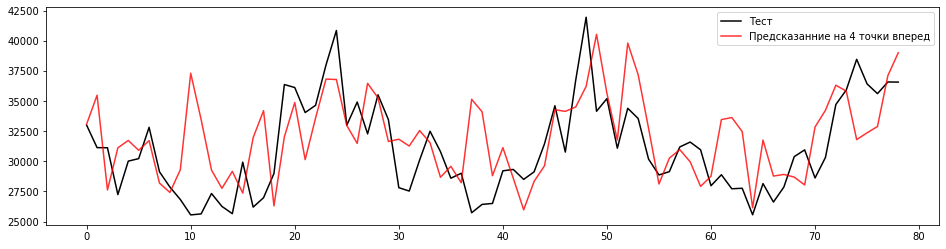

In [11]:
X_train_4, y_train_4, X_test_4, y_test_4 = split_h(data_p, split_date, h=4)
model_4 = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=1000)
model_4.fit( X_train_4, y_train_4 ) 
y_test_4_pred = model_4.predict(X_test_4)
plt.figure(figsize = (16,4))
plt.plot(y_test_4, label='Тест', c='black')
plt.plot(y_test_4_pred, label='Предсказанние на 4 точки вперед',c='r',alpha=0.8)
plt.legend()
plt.show()

In [12]:
mean_absolute_percentage_error(y_test_4, y_test_4_pred)

9.448261994464028

### ГЛУБИНА ПРОГНОЗА h=1

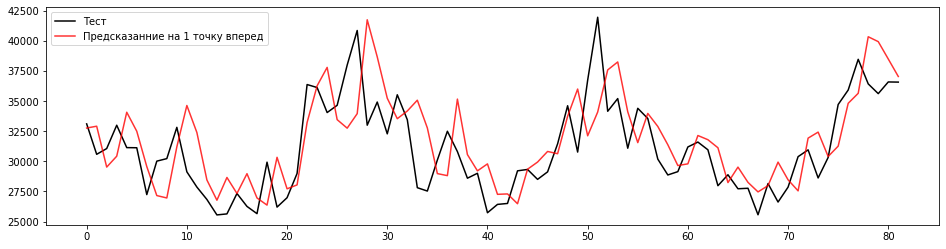

In [13]:
X_train_1, y_train_1, X_test_1, y_test_1 = split_h(data_p, split_date, h=1)
model_1 = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=1000)
model_1.fit( X_train_1, y_train_1 ) 
y_test_1_pred = model_1.predict(X_test_1)
plt.figure(figsize = (16,4))
plt.plot(y_test_1, label='Тест', c='black')
plt.plot(y_test_1_pred, label='Предсказанние на 1 точку вперед',c='r',alpha=0.8)
plt.legend()
plt.show()

In [14]:
mean_absolute_percentage_error(y_test_1, y_test_1_pred)

7.9048835169380816

### Рекурсивное предсказание по одной точке на 4 точки вперед 

In [15]:
# предсказание на точку вперед, 
# восстановление признаков по ней, 
# предсказание новой точки по полученным признакам 
# и снова востановление признаков по предсказанному... 
# ... и так n раз
def rec(obj, n, model):
    x0 = obj.reshape(1,-1)
    pred = model.predict(x0)[0]
    
    for i in range(n-1):
        x0 = np.array([pred, x0[0][0], 0.3 * pred + (1 - 0.3) * x0[0][0], pred-x0[0][0]]).reshape(1,-1)
        pred = model_1.predict(x0)
    return pred

Рекурсивное прдсказание на 4 точки вперед для тестовой выборки

In [16]:
y_pred_4_1 = np.array([rec(obj, 4, model_1) for obj in X_test_4.values]).reshape(-1,)
y_pred_4_1.shape

(79,)

In [17]:
y_test_4.shape

(79,)

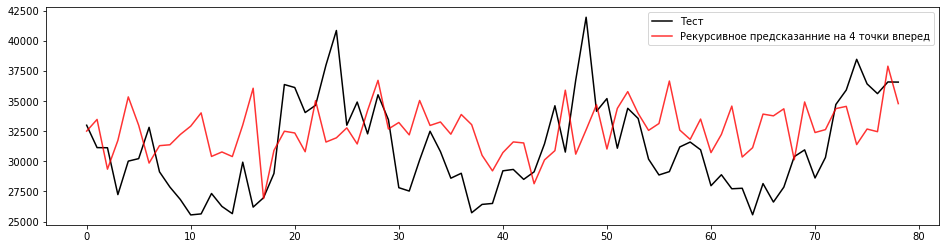

In [18]:
plt.figure(figsize = (16,4))
plt.plot(y_test_4, label='Тест', c='black')
plt.plot(y_pred_4_1, label='Рекурсивное предсказанние на 4 точки вперед',c='r',alpha=0.8)
plt.legend()
plt.show()

In [19]:
mean_absolute_percentage_error(y_test_4, y_pred_4_1)

11.789209228047106

## Оценка прямого предсказания на 4 точки вперед выше, чем рекурсивного.
## MAPE:
### ПРЯМОЕ: 7.91 %
### РЕКУРСИВНОЕ: 11.79 %

С 5-й и 6-й задачами пока не справился, потом вернусь